안녕하세요. 새삥_H의 WOONGSONVI 라고 합니다.  
공모전 대회는 매번 참여했었지만 100등 안에 들었던 적이 한 번도 없었는데  
생각보다 높은 등수를 기록해서 너무 기쁘네요 ㅠㅠ

저희는 Amazon Sagemaker Studio Lab을 이용했습니다.  
변수 선택 작업과 AutoML을 통해 CatBoost를 채택했고,  
Knowledge Distillation을 이용하여 결과를 만들었습니다.  

끝으로 좋은 인사이트를 제공해주신 Statistics님과  
다른 대회지만 모델링 코드를 공유해주신 자강사123님  
그리고 코드 공유와 토크 게시판에서 많은 도움을 주신 참여자분들과 데이콘 임직원분들께 감사의 말씀을 드립니다.  
아직 많이 부족하니 사소한 것이라도 의견 남겨주시면 감사드리겠습니다! :)

# 0. 패키지 불러오기

In [1]:
!pip install catboost
!pip install optuna

  Using cached scipy-1.8.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (42.2 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.4
    Uninstalling scipy-1.5.4:
      Successfully uninstalled scipy-1.5.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.2.1 requires scipy<1.6,>=1.0.0, but you have scipy 1.8.1 which is incompatible.
pycaret 2.3.10 requires scipy<=1.5.4, but you have scipy 1.8.1 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

from scipy.stats import ranksums

from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.metrics import mean_absolute_error, roc_auc_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostClassifier, CatBoostRegressor

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

import random
from collections import Counter

import pickle

import warnings
warnings.filterwarnings(action = 'ignore')

In [3]:
# 라이브러리 버전 확인
!pip list

Package                       Version
----------------------------- -----------
alembic                       1.8.1
annoy                         1.17.1
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
attrs                         22.1.0
autopage                      0.5.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
beautifulsoup4                4.11.1
bleach                        5.0.1
blis                          0.7.9
Boruta                        0.3
catalogue                     1.0.2
catboost                      1.1.1
category-encoders             2.5.1.post0
certifi                       2022.9.24
cffi                          1.15.1
charset-normalizer            2.1.1
click                         8.1.3
cliff                         4.1.0
cloudpickle                   2.2.0
cmaes                         0.9.0
cmd2                          2.4.2
colorlog                      6.7.0
colorlover                    0.3.0
common

# 1. 데이터 확인

이번 대회의 가장 큰 특징은 train 데이터와 test 데이터의 변수 개수가 서로 다르다는 점이라고 생각합니다.  
train 데이터는 총 53개의 변수(ID 변수는 제외)를 가지고 있지만  
test 데이터는 그 중의 일부인 18개(ID 변수는 제외)의 변수를 가지고 있었습니다.  
따라서 Knowledge Distillation을 이용하여 Teacher model에서는 정상과 불량을 잘 분류해주는 모델을,  
Student model에서는 적은 변수로도 Teacher model을 잘 설명해줄 수 있는 모델을 만들기로 했습니다.   
저희는 test 데이터가 가지고 있는 18개의 변수보다 더 많은 변수로 Teacher 분류 모델을 만들고,   
predict_proba를 이용해 각 작동 오일에 대한 예측불량률(0 ~ 1 사이의 값)을 구한 다음,  
test 데이터가 가지고 있는 18개의 변수 혹은 그 이하 개수의 변수를 이용하여  
앞에서의 예측불량률을 다시 예측하는 Student 회귀 모델을 만들었습니다.

In [4]:
path = '/home/studio-lab-user/MYDATA/Construction Machine Oil/open/'

Rdata_train = pd.read_csv(path + 'train.csv')
Rdata_test = pd.read_csv(path + 'test.csv')

print(Rdata_train.shape)
print(Rdata_train.size)
print(Rdata_test.shape)
print(Rdata_test.size)
Rdata_train.head()

(14095, 54)
761130
(6041, 19)
114779


,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,1486,2011,7,200,0,3,93,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,154.0,75,0
1,TRAIN_00001,COMPONENT2,1350,2021,51,375,0,2,19,0,...,2.0,4.0,6.0,216.0,1454.0,0,NaN,44.0,652,0
2,TRAIN_00002,COMPONENT2,2415,2015,2,200,0,110,1,1,...,0.0,3.0,39.0,11261.0,41081.0,0,NaN,72.6,412,1
3,TRAIN_00003,COMPONENT3,7389,2010,2,200,0,8,3,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.3,7,0
4,TRAIN_00004,COMPONENT3,3954,2015,4,200,0,1,157,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.1,128,0


In [5]:
Rdata_test.head()

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
0,TEST_0000,COMPONENT1,2192,2016,200,0,0,0,1,12,0.0,0,0,0,10,0,0,91.3,1091
1,TEST_0001,COMPONENT3,2794,2011,200,0,0,2,1,278,0.0,3,0,0,2732,1,0,126.9,12
2,TEST_0002,COMPONENT2,1982,2010,200,0,0,0,16,5,0.0,0,0,0,11,0,0,44.3,714
3,TEST_0003,COMPONENT3,1404,2009,200,0,0,3,4,163,0.0,4,3,0,8007,0,0,142.8,94
4,TEST_0004,COMPONENT2,8225,2013,200,0,0,0,6,13,0.0,0,0,0,16,0,0,63.4,469


1. COMPONENT_ARBITRARY : 샘플 오일 관련 부품 (Component 4종, 비식별화) : 명목형
2. ANONYMOUS_1 : 무명 Feautre 1. 수치형 데이터
3. YEAR : 오일 샘플 및 진단 해 (Year)
4. SAMPLE_TRANSFER_DAY : 오일 샘플링 후 진단 기관으로 이동한 기간 (Days)
5. ANONYMOUS_2 : 무명 Feautre 2. 수치형 데이터
6. AG : 원소기호 AG - Silver 함유량
7. AL : 원소기호 AL - Aluminium 함유량
8. B : 원소기호 B - Boron 함유량
9. BA : 원소기호 BA -  Barium 함유량
10. BE : 원소기호 BE - Beryllium 함유량
11. CA : 원소기호 CA - Calcium 함유량
12. CD : 원소기호 CD - Cadmium 함유량
13. CO : 원소기호 CO - Cobolt 함유량
14. CR : 원소기호 CR - Chromium 함유량
15. CU : 원소기호 CU - Copper 함유량
16. FH2O : Water 수치(By FT-IR)
17. FNOX : NOx 수치(By FT-IR)
18. FOPTIMETHGLY : 비식별화
19. FOXID : Oxidation 수치(By FT-IR)
20. FSO4 : SO4 수치(By FT-IR)
21. FTBN : 염기성 첨가제물질 수치(By FT-IR)
22. FE : 원소기호 FE - Iron 함유량
23. FUEL : 연료 함유량
24. H2O : Water 함유량
25. K : 원소기호 K - Potassium 함유량
26. LI : 원소기호 LI - Lithium 함유량
27. MG : 원소기호 MG - Magnesium 함유량
28. MN : 원소기호 MN - Manganese 함유량
29. MO : 원소기호 MO - Molybdenum 함유량
30. NA : 원소기호 NA - Sodium 함유량
31. NI : 원소기호 NI - Nickel 함유량
32. P : 원소기호 P - Phosphorus 함유량
33. PB : 원소기호 PB - Lead 함유량
34. PQINDEX : Particle Quantifier Index
35. S : 원소기호 S - Sulphur 함유량
36. SB : 원소기호 SB - Antimony 함유량
37. SI : 원소기호 SI - Silicone 함유량
38. SN : 원소기호 SN - Tin 함유량
39. SOOTPERCENTAGE : Soot 함유량(%)
40. TI : 원소기호 TI - Titanium 함유량
41. U100 : Particle Count (100㎛ 이상 크기 입자)
42. U75 : Particle Count (75㎛ 이상 크기 입자)
43. U50 : Particle Count (50㎛ 이상 크기 입자)
44. U25 : Particle Count (25㎛ 이상 크기 입자)
45. U20 : Particle Count (20㎛ 이상 크기 입자)
46. U14 : Particle Count (14㎛ 이상 크기 입자)
47. U6 : Particle Count (6㎛ 이상 크기 입자)
48. U4 : Particle Count (4㎛ 이상 크기 입자)
49. V : 원소기호 V - Vanadium 함유량
50. V100 : Viscosity @ 100 degrees
51. V40 : Viscosity @ 40 degrees
52. ZN : 원소기호 ZN - Zinc 함유량
53. Y_LABEL : 오일 정상 여부 (0 : 정상, 1 : 이상)

먼저 결측이 있는 변수들을 확인했습니다.  
test 데이터에는 없었으며, train 데이터에는 총 19개의 변수에 결측 데이터가 존재했습니다.  
작동 오일에 대한 도메인 지식을 보았을 때, 입자 데이터나 수분 함량 등  
19개 변수 중 작동 오일의 불량에 영향을 끼치는 변수들이 많았지만,  
대다수가 절반 이상이 결측되어 있었기 때문에  
결측치 대체를 하더라도 좋은 결과가 나오지 않을 것이라 판단했습니다.  
따라서, 결측률이 20% 이하인 CD와 K는 이용해보기로 판단했고,  
이를 제외한 나머지 17개의 변수들과 ID 변수는 제거했습니다.

In [6]:
# 결측치가 있는 변수 개수 파악

mis_val = Rdata_train.isnull().sum()
mis_val_bool = mis_val >= 1
mis_val_df = pd.concat([mis_val, mis_val_bool], axis = 1)
mis_val_df = mis_val_df.rename(columns = {0 : 'mis_val', 1 : 'mis_val_bool'})

print("결측이 있는 변수")
print(mis_val_df['mis_val_bool'].value_counts())

결측이 있는 변수
False    35
True     19
Name: mis_val_bool, dtype: int64


In [7]:
# 결측치가 있는 변수 및 결측률 파악

mis_val_data = mis_val_df.loc[mis_val_df['mis_val_bool'] == True, :]
mis_val_data['ratio'] = mis_val_data['mis_val'] / 14095
mis_val_data

,mis_val,mis_val_bool,ratio
CD,1394,True,0.098900
FH2O,10205,True,0.724016
FNOX,10205,True,0.724016
FOPTIMETHGLY,10205,True,0.724016
FOXID,10205,True,0.724016
FSO4,10205,True,0.724016
FTBN,10205,True,0.724016
FUEL,10205,True,0.724016
K,2299,True,0.163107
SOOTPERCENTAGE,10205,True,0.724016


In [8]:
# 결측률이 20% 이상인 변수들 제거

notnull_columns = Rdata_train.loc[:, Rdata_train.notnull().sum(axis = 0) == 14095].columns
notnull_columns = notnull_columns[1 :]
notnull_columns = list(notnull_columns)

select_columns = notnull_columns[: 32] + ['K', 'CD'] + notnull_columns[32 :]
Rdata_train2 = Rdata_train.loc[:, select_columns]
print(Rdata_train2.shape)
print(Rdata_train2.columns)

(14095, 36)
Index(['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR', 'SAMPLE_TRANSFER_DAY',
       'ANONYMOUS_2', 'AG', 'AL', 'B', 'BA', 'BE', 'CA', 'CO', 'CR', 'CU',
       'FE', 'H2O', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI', 'P', 'PB', 'PQINDEX',
       'S', 'SB', 'SI', 'SN', 'TI', 'V', 'V40', 'K', 'CD', 'ZN', 'Y_LABEL'],
      dtype='object')


# 2. 변수 선택

먼저 train 데이터와 test 데이터 둘 다 포함되어 있는 18개의 변수를 살펴보았습니다.  
이 변수들은 큰 문제가 아니라면 Teacher 모델과 Student 모델에 모두 넣고자 했습니다.  
그래야 Student 모델을 이용해 Teacher 모델의 예측불량률을 잘 설명해주는 모델이 나올 것이라고 판단했습니다.  

상관분석을 통해 변수 간의 상관계수의 절댓값이 0.7 이상의 값이 있는지를 확인했는데  
0.6의 상관관계는 있었지만, 그 이상의 값은 없었기 때문에  
18개의 변수를 모두 Teacher model과 Student model에 넣는 것이 좋을 것이라 판단했습니다.  
따라서, Student model은 18개의 변수를 모두 이용하는 것으로 최종 확정했습니다.

In [9]:
# train 데이터, test 데이터에 모두 포함되어 있는 변수 18개의 상관관계 분석

t = Rdata_train2.copy()
corr = t.corr()
corr.style.background_gradient(cmap = 'coolwarm')

# TI와 V : 0.678
# FE와 SI : 0.649
# NI와 SI : 0.630
# FE와 MN : 0.622
# S와 V40 : 0.607
# SI와 TI : 0.606
# SI와 K : 0.605
# MN와 TI : 0.585
# FE와 NI : 0.583
# MN와 SI : 0.554
# CO와 FE : 0.537
# MN와 NI : 0.583
# TI와 K : 0.524
# MN와 K : 0.511

,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,CA,CO,CR,CU,FE,H2O,LI,MG,MN,MO,NA,NI,P,PB,PQINDEX,S,SB,SI,SN,TI,V,V40,K,CD,ZN,Y_LABEL
ANONYMOUS_1,1.000000,0.106546,-0.041395,0.072154,-0.025674,0.017924,0.013467,-0.064204,-0.010805,-0.015321,-0.003783,-0.007035,-0.014086,0.000440,0.003868,0.000944,-0.001807,-0.004212,-0.006206,0.000183,-0.007862,-0.013647,-0.000499,0.002277,0.016374,-0.011797,0.005141,-0.009564,0.001832,0.001883,0.019542,-0.004384,0.010076,-0.019991,0.044197
YEAR,0.106546,1.000000,-0.094086,0.138199,-0.129124,-0.017525,0.011145,-0.098589,-0.063859,0.090465,-0.052337,-0.028871,-0.137593,-0.057709,0.009855,0.002697,0.025616,-0.039132,-0.091482,0.028953,-0.049206,-0.143675,-0.031021,-0.067160,-0.141084,-0.019612,0.011831,-0.065335,0.006399,-0.027624,-0.051584,-0.032801,-0.012668,0.048572,-0.087871
SAMPLE_TRANSFER_DAY,-0.041395,-0.094086,1.000000,-0.000060,0.021211,-0.017493,0.004305,0.016909,0.009600,0.008826,0.002195,-0.001495,0.006303,0.011651,-0.007926,-0.002275,0.008802,0.006816,0.001051,-0.006263,0.015599,-0.009730,0.000543,0.033622,0.014327,-0.015647,0.007713,0.006986,-0.002855,-0.002412,0.013896,0.012344,-0.006108,-0.019428,-0.004315
ANONYMOUS_2,0.072154,0.138199,-0.000060,1.000000,-0.006266,-0.022788,-0.100307,-0.011871,0.011162,-0.043046,-0.000070,-0.001826,-0.002244,-0.004608,-0.003760,-0.002483,-0.003306,0.003304,-0.008465,0.000647,-0.003914,0.000771,0.000519,-0.010409,-0.033153,0.006001,0.007633,0.004799,-0.000981,-0.006469,-0.025339,-0.003246,0.012702,0.032758,-0.033641
AG,-0.025674,-0.129124,0.021211,-0.006266,1.000000,0.019600,-0.028131,0.031649,0.020884,-0.004489,0.008861,0.005397,0.051046,0.025959,-0.003850,0.002394,-0.009523,0.019507,0.013124,-0.007197,0.054014,0.024517,0.020716,0.030929,0.017271,0.028327,0.020739,0.016582,0.003609,-0.003853,0.013592,0.013082,0.004325,0.002631,0.014671
AL,0.017924,-0.017525,-0.017493,-0.022788,0.019600,1.000000,0.000037,0.240863,-0.000858,-0.070322,0.009920,0.011430,0.037530,0.051138,-0.000093,0.000008,-0.001625,0.033695,-0.002615,-0.002290,0.099946,-0.022301,-0.004914,0.030492,0.011343,0.003998,0.087274,-0.006664,0.062613,0.026213,0.013823,0.037586,-0.004580,-0.024873,0.370512
B,0.013467,0.011145,0.004305,-0.100307,-0.028131,0.000037,1.000000,-0.045454,-0.013252,0.356121,0.005536,0.003759,0.000142,0.003075,-0.005442,0.015888,0.003456,0.000792,-0.001100,0.004937,0.010686,-0.004137,0.008009,-0.003177,0.005926,-0.019423,0.004165,-0.000990,0.008712,0.018197,-0.000882,-0.004724,-0.018408,-0.006463,-0.029787
BA,-0.064204,-0.098589,0.016909,-0.011871,0.031649,0.240863,-0.045454,1.000000,0.029900,-0.008642,0.004970,0.000443,0.023212,0.012627,-0.005055,-0.005337,-0.006470,0.007149,-0.004351,-0.004076,0.018465,0.003426,0.000497,0.003411,0.013244,0.006005,0.010588,0.004767,0.005074,0.000480,0.004150,0.007964,-0.001110,-0.009574,0.104840
BE,-0.010805,-0.063859,0.009600,0.011162,0.020884,-0.000858,-0.013252,0.029900,1.000000,0.006735,0.014084,0.002712,-0.001388,0.002707,-0.001610,-0.000977,0.045744,-0.000759,0.000208,-0.005445,0.001227,0.024291,0.006927,-0.000746,0.002929,0.007266,-0.002948,0.025744,-0.002501,0.000482,0.001359,0.003115,-0.002690,0.012394,0.010685
CA,-0.015321,0.090465,0.008826,-0.043046,-0.004489,-0.070322,0.356121,-0.008642,0.006735,1.000000,0.001185,-0.015970,0.008900,-0.012488,-0.013057,-0.003960,0.023333,0.011866,-0.001413,0.014019,-0.003472,0.032399,0.022724,-0.003129,-0.078747,0.022265,-0.006390,-0.006153,-0.013781,-0.014419,-0.059102,-0.007404,-0.005770,0.110625,-0.150379


다음으로 train 데이터에는 존재하나, test 데이터에는 존재하지 않는 변수 중  
어떤 변수를 Teacher model에 넣을지를 판단했습니다.  
추가 변수는 잠정적으로 2~3개로 정했습니다.  
적은 개수의 변수를 Teacher model에 추가하는 이유는  
train 데이터에는 존재하지만 test 데이터에는 존재하지 않는 변수가 많이 추가된다면  
Teacher model에서는 성능이 좋지만, Student model에는 18개의 변수 밖에 없기 때문에  
Teacher model의 예측불량률을 잘 설명하지 못할 것이라 판단했습니다.  

변수를 추가하는 기준은 아래와 같이 정했습니다.

(1) Wilcoxon 순위합 검정의 P-value  
(2) 이상 범위 데이터의 불량 개수와 불량률  
(3) 불량 데이터의 중위수가 그 변수의 이상 범위에 존재하는지 유무  

### (1) Wilcoxon 순위합 검정의 P-value

가장 먼저 Wilcoxon 순위합 검정을 통해 17개의 변수 중 1차 변수를 선택하고자 했습니다.  
저희는 불량을 잘 분류할 수 있는 변수라면  
정상 범위의 데이터와 이상 범위의 데이터 사이에 차이가 있을 것이라고 판단했습니다.  
특히, 이상 범위의 데이터의 변수 값이 정상 범위의 데이터보다 더 클 것이라고 생각했습니다.  

따라서 IQR을 이용하여 정상 범위와 이상 범위를 구분 짓는 함수를 만들었고,  
Wilcoxon 순위합 검정을 통해 [이상 집단이 정상 집단보다 큰 값을 가진다]라는 귀무가설에 대한  
비모수 검정을 실시했습니다.  

모수 검정인 ANOVA 대신 비모수 검정인 Wilcoxon 검정을 사용한 이유는  
모든 변수에 대해 EDA를 진행했을 때, 대부분의 변수들이 정규분포가 아닌 0쪽으로 치우쳐진 분포를 가지고 있었기 때문입니다.  
이런 경우에는 정규분포 가정이 필요한 ANOVA는 유효하지 않기 때문에  
Wilcoxon 검정을 사용했습니다.

In [10]:
# IQR을 이용하여 정상 범위 추출하기

def IQR_outlier(data) :
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - (1.5 * IQR) 
    upper_bound = Q3 + (1.5 * IQR)

    return pd.concat([lower_bound, upper_bound], axis = 1).T

검정 결과, P_value가 0.05 이하인 변수들만 추출하여  
17개의 변수 중 1차 변수로 7개의 변수를 선별했습니다.

In [11]:
# 정상 범위와 이상 범위의 데이터 간 윌콕슨 순위합 검정 실시

ranksum_p = []
variable_17 = ['SAMPLE_TRANSFER_DAY', 'AL', 'B', 'BA', 'BE', 'CA', 'CD', 'K', 'LI', 'MG', 'NA', 'P', 'PB', 'S', 'SB', 'SI', 'SN']

# alternative = 'greater'을 걸어줘서 한쪽 검정으로 실시
# scipy 1.8.1 버전 이상이어야 ranksums의 옵션인 alternative(한쪽 검정) 사용 가능
for v in variable_17 :
  temp = ranksums(Rdata_train.loc[(Rdata_train['Y_LABEL'] == 1) & (Rdata_train[v].notnull()), v], 
                  Rdata_train.loc[(Rdata_train['Y_LABEL'] == 0) & (Rdata_train[v].notnull()), v],
                  alternative = 'greater').pvalue
  ranksum_p.append(temp)

Wilcoxon_var_table = pd.DataFrame({'variable' : variable_17,
                                   'p_value' : ranksum_p,
                                   'p_value_round' : np.round(ranksum_p, 4)})
Wilcoxon_var_table.sort_values('p_value')


,variable,p_value,p_value_round
1,AL,2.219279e-275,0.0000
3,BA,5.228798e-75,0.0000
13,S,1.055174e-04,0.0001
7,K,1.367787e-04,0.0001
15,SI,2.850652e-03,0.0029
16,SN,5.595753e-03,0.0056
14,SB,8.677268e-03,0.0087
8,LI,1.138419e-01,0.1138
12,PB,1.590474e-01,0.1590
6,CD,3.667412e-01,0.3667


In [12]:
# P_value가 0.05 이하인 변수만 추출
Wilcoxon_var_table.loc[Wilcoxon_var_table['p_value'] <= 0.05, :].sort_values('p_value')

,variable,p_value,p_value_round
1,AL,2.219279e-275,0.0000
3,BA,5.228798e-75,0.0000
13,S,1.055174e-04,0.0001
7,K,1.367787e-04,0.0001
15,SI,2.850652e-03,0.0029
16,SN,5.595753e-03,0.0056
14,SB,8.677268e-03,0.0087


In [13]:
Wilcoxon_var_table.loc[Wilcoxon_var_table['p_value'] <= 0.05, 'variable']

1     AL
3     BA
7      K
13     S
14    SB
15    SI
16    SN
Name: variable, dtype: object

### (2) 이상 범위 데이터의 불량 개수와 불량률

7개의 변수들이 실제로 불량을 잘 분류하는 변수인지  
정상 범위와 이상 범위로 나눈 후,  
불량 개수와 불량률이 높은 순으로 table을 만들었습니다.

In [14]:
# 각 변수에 대해 '정상 범위 데이터 개수', '이상 범위 데이터 개수', '전체 데이터 합계', 
#               '정상 범위 데이터의 불량 개수', '이상 범위 데이터의 불량 개수', '불량 합계',
#               '정상 범위 데이터의 불량률', '이상 범위 데이터의 불량률'
# 에 대한 Table 생성

variable_7 = ['AL', 'BA', 'K', 'S', 'SB', 'SI', 'SN']

outlier_table = pd.DataFrame(np.zeros([8, len(variable_7)]), columns = variable_7,
                             index = ['정상 범위 데이터 개수', '이상 범위 데이터 개수', '전체 데이터 합계', 
                                      '정상 범위 데이터의 불량 개수', '이상 범위 데이터의 불량 개수', '불량 합계',
                                      '정상 범위 데이터의 불량률', '이상 범위 데이터의 불량률'])

for v in variable_7 :
  temp1 = Rdata_train2.loc[(IQR_outlier(Rdata_train2).loc[0, v] <= Rdata_train2[v]) & 
                        (Rdata_train2[v] <= IQR_outlier(Rdata_train2).loc[1, v]), :]
  temp2 = Rdata_train2.loc[(IQR_outlier(Rdata_train2).loc[0, v] > Rdata_train2[v]) | (Rdata_train2[v] > IQR_outlier(Rdata_train2).loc[1, v]), :]
  
  outlier_table.at['정상 범위 데이터 개수', v] = temp1.shape[0]
  outlier_table.at['이상 범위 데이터 개수', v] = temp2.shape[0]
  outlier_table.at['전체 데이터 합계', v] = temp1.shape[0] + temp2.shape[0]

  temp3 = temp1.loc[Rdata_train2['Y_LABEL'] == 1, :]
  temp4 = temp2.loc[Rdata_train2['Y_LABEL'] == 1, :]
  outlier_table.at['정상 범위 데이터의 불량 개수', v] = temp3.shape[0]
  outlier_table.at['이상 범위 데이터의 불량 개수', v] = temp4.shape[0]
  outlier_table.at['불량 합계', v] = temp3.shape[0] + temp4.shape[0]  

  if temp1.shape[0] == 0 :
    temp5 = 0
  else :
    temp5 = np.round(temp3.shape[0] / temp1.shape[0] * 100, 3)
  outlier_table.at['정상 범위 데이터의 불량률', v] = temp5 

  if temp2.shape[0] == 0 :
    temp6 = 0
  else :
    temp6 = np.round(temp4.shape[0] / temp2.shape[0] * 100, 3)    
  outlier_table.at['이상 범위 데이터의 불량률', v] = temp6

outlier_table = outlier_table.T

이상 범위 데이터의 불량 개수를 많은 순으로 보았을 때,  
AL, BA, SB, SI, K 순으로 많은 것을 볼 수 있습니다.

In [15]:
outlier_table.nlargest(len(variable_17), columns = ['이상 범위 데이터의 불량 개수'])

,정상 범위 데이터 개수,이상 범위 데이터 개수,전체 데이터 합계,정상 범위 데이터의 불량 개수,이상 범위 데이터의 불량 개수,불량 합계,정상 범위 데이터의 불량률,이상 범위 데이터의 불량률
AL,12651.0,1444.0,14095.0,506.0,697.0,1203.0,4.000,48.269
BA,10780.0,3315.0,14095.0,585.0,618.0,1203.0,5.427,18.643
SB,11128.0,2967.0,14095.0,902.0,301.0,1203.0,8.106,10.145
SI,12246.0,1849.0,14095.0,1004.0,199.0,1203.0,8.199,10.763
K,10738.0,1058.0,11796.0,854.0,141.0,995.0,7.953,13.327
SN,12778.0,1317.0,14095.0,1087.0,116.0,1203.0,8.507,8.808
S,14088.0,7.0,14095.0,1202.0,1.0,1203.0,8.532,14.286


이상 범위 데이터의 불량률을 높은 순으로 보았을 때,  
AL, BA, S, K, SI 순으로 높은 것을 볼 수 있습니다.  
특히 AL의 이상 범위 데이터의 불량률은 48%로  
다른 변수보다 불량을 잘 잡아내는 것을 볼 수 있었습니다.

In [16]:
outlier_table.nlargest(len(variable_17), columns = ['이상 범위 데이터의 불량률'])

,정상 범위 데이터 개수,이상 범위 데이터 개수,전체 데이터 합계,정상 범위 데이터의 불량 개수,이상 범위 데이터의 불량 개수,불량 합계,정상 범위 데이터의 불량률,이상 범위 데이터의 불량률
AL,12651.0,1444.0,14095.0,506.0,697.0,1203.0,4.000,48.269
BA,10780.0,3315.0,14095.0,585.0,618.0,1203.0,5.427,18.643
S,14088.0,7.0,14095.0,1202.0,1.0,1203.0,8.532,14.286
K,10738.0,1058.0,11796.0,854.0,141.0,995.0,7.953,13.327
SI,12246.0,1849.0,14095.0,1004.0,199.0,1203.0,8.199,10.763
SB,11128.0,2967.0,14095.0,902.0,301.0,1203.0,8.106,10.145
SN,12778.0,1317.0,14095.0,1087.0,116.0,1203.0,8.507,8.808


### (3) 불량 데이터의 중위수가 그 변수의 이상 범위에 존재하는지 유무  

(1)과 (2)의 결과를 통해 AL, BA가 중요한 변수임을 알 수 있었으나,  
이 외에도 중요한 변수가 있는지를 파악해야 할 필요성이 있었습니다.  
저희는 불량 데이터만 따로 추출해서 어느 변수의 중위수를 구했을 때,  
만약 그 값이 어느 변수의 이상 범위에 존재한다면, 불량을 잘 구분해낼 수 있는 능력이 있는 변수라 판단했습니다.  

실제로 7개의 변수를 분석해 본 결과,
AL과 BA 만이 불량 데이터의 중위수가 이상 범위에 위치해 있었던 변수임을 알 수 있었습니다.  
따라서 AL, BA 두 변수만을 Teacher model에 넣는 것이 좋겠다고 생각했습니다.

In [17]:
variable = variable_7

target_var = []

for v in variable :
  
  print(v)

  LB = IQR_outlier(Rdata_train).loc[0, v]
  RB = IQR_outlier(Rdata_train).loc[1, v]
  Defect_Q50 = Rdata_train.loc[(Rdata_train['Y_LABEL'] == 1) & (Rdata_train[v].notnull()), v].quantile(0.5)
  
  print(LB, Defect_Q50, RB)

  if (Defect_Q50 < LB) or (Defect_Q50 > RB) :
    target_var.append(v)
  else :
    continue

AL
-3.5 22.0 8.5
BA
0.0 1.0 0.0
K
-4.5 2.0 7.5
S
-18523.75 9422.0 42714.25
SB
0.0 0.0 0.0
SI
-10.5 7.0 25.5
SN
-1.5 0.0 2.5


In [18]:
target_var

['AL', 'BA']

# 3. 모델 선택

저희는 머신러닝 기반의 모델을 사용하는 것이 좋다고 판단했습니다.  
딥러닝 모델을 선택하지 않은 이유는 train 데이터와 test 데이터가 10000개 내외로 적은 수를 가진 정형 데이터 형식이었기 때문에  
머신러닝 모델을 사용하는 것이 데이터를 더 잘 설명할 수 있을 것이라 판단했습니다.  
AutoML인 pycaret을 이용해 Teacher model과 Student model에서 사용할 모델을 선택했습니다.

In [19]:
!pip install pycaret

  Using cached scipy-1.5.4-cp39-cp39-manylinux1_x86_64.whl (25.8 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.8.1
    Uninstalling scipy-1.8.1:
      Successfully uninstalled scipy-1.8.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
optuna 3.0.3 requires scipy<1.9.0,>=1.7.0, but you have scipy 1.5.4 which is incompatible.


In [20]:
AUTO_ML_train1 = Rdata_train.copy()
AUTO_ML_test1 = Rdata_test.copy()

In [21]:
AUTO_ML_train2 = AUTO_ML_train1.loc[:, ['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR', 'ANONYMOUS_2', 'AG',
                                        'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
                                        'V40', 'ZN', 'Y_LABEL', 'AL', 'BA']]
AUTO_ML_test2 = AUTO_ML_test1.drop(['ID'], axis = 1)

print(AUTO_ML_train2.shape)
print(AUTO_ML_test2.shape)

(14095, 21)
(6041, 18)


In [22]:
# 범주형 변수인 COMPONENT_ARBITRARY와 YEAR를 LabelEncoder 변환

le1 = LabelEncoder()
le2 = LabelEncoder()

AUTO_ML_train2['COMPONENT_ARBITRARY_category'] = le1.fit_transform(AUTO_ML_train2['COMPONENT_ARBITRARY'])
AUTO_ML_train2['YEAR_category'] = le2.fit_transform(AUTO_ML_train2['YEAR'])

AUTO_ML_test2['COMPONENT_ARBITRARY_category'] = le1.transform(AUTO_ML_test2['COMPONENT_ARBITRARY'])
AUTO_ML_test2['YEAR_category'] = le2.transform(AUTO_ML_test2['YEAR'])

AUTO_ML_train3 = AUTO_ML_train2.drop(['COMPONENT_ARBITRARY', 'YEAR'], axis = 1)
AUTO_ML_test3 = AUTO_ML_test2.drop(['COMPONENT_ARBITRARY', 'YEAR'], axis = 1)

categorical_features = ['COMPONENT_ARBITRARY_category', 'YEAR_category']
numeric_features = ['ANONYMOUS_1', 'ANONYMOUS_2', 'AG', 'CO', 'CR', 'CU', 
                    'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN', 'AL', 'BA']

In [23]:
from pycaret.classification import *

clf = setup(AUTO_ML_train3, 
            target = 'Y_LABEL', 
            categorical_features = categorical_features,
            numeric_features = numeric_features,
            normalize = True,
            iterative_imputation_iters = 10,
            train_size = 0.7,
            session_id = 42)

,Description,Value
0,session_id,42
1,Target,Y_LABEL
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(14095, 21)"
5,Missing Values,False
6,Numeric Features,18
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


여러 번에 걸쳐 pycaret을 실행하였고, f1 score가 높은 순으로 model을 정렬해 본 결과,  
catboost 성능이 대부분 최상위권에 위치하여 데이터를 설명하는 데에 있어서 가장 좋은 모델임을 확인할 수 있었습니다.  
따라서 Teacher model은 CatBoostClassifier로 결정했습니다.  

Student model을 위해 가장 좋은 모델 5개를 Ensemble하여 예측 불량률을 구합니다.

In [24]:
# Teacher model 학습 이후 성능이 높은 순으로 정렬

best5 = compare_models(fold = 5, sort = 'f1', n_select = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9539,0.8788,0.5134,0.9244,0.6594,0.6369,0.6691,4.0380
lightgbm,Light Gradient Boosting Machine,0.9534,0.8689,0.5110,0.9181,0.6558,0.6330,0.6648,0.2220
ada,Ada Boost Classifier,0.9536,0.8611,0.5076,0.9277,0.6555,0.6330,0.6665,0.3040
gbc,Gradient Boosting Classifier,0.9527,0.8768,0.5145,0.8995,0.6542,0.6309,0.6595,0.8820
rf,Random Forest Classifier,0.9537,0.8591,0.4994,0.9431,0.6524,0.6301,0.6672,0.6020
lr,Logistic Regression,0.9521,0.8546,0.4797,0.9427,0.6352,0.6125,0.6531,0.7580
svm,SVM - Linear Kernel,0.9494,0.0000,0.4762,0.8989,0.6206,0.5963,0.6320,0.0480
et,Extra Trees Classifier,0.9476,0.8517,0.4205,0.9529,0.5827,0.5593,0.6134,0.5340
nb,Naive Bayes,0.9116,0.8150,0.5540,0.4987,0.5239,0.4755,0.4768,0.0380
dt,Decision Tree Classifier,0.9122,0.7466,0.5459,0.4993,0.5203,0.4722,0.4735,0.0740


In [25]:
blended = blend_models(estimator_list = best5, fold = 5, optimize = 'f1')
pred_holdout = predict_model(blended)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9524,0.8611,0.4971,0.9247,0.6466,0.6235,0.6582
1,0.9488,0.8638,0.4593,0.9080,0.6100,0.5858,0.6250
2,0.9524,0.8962,0.4767,0.9535,0.6357,0.6132,0.6556
3,0.9584,0.9144,0.5640,0.9327,0.7029,0.6820,0.7070
4,0.9579,0.8610,0.5523,0.9406,0.6960,0.6750,0.7027
Mean,0.9540,0.8793,0.5099,0.9319,0.6582,0.6359,0.6697
Std,0.0037,0.0220,0.0413,0.0152,0.0357,0.0370,0.0310


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.9555,0.8651,0.4912,0.9231,0.6412,0.6199,0.6551


In [26]:
final_model = finalize_model(blended)

In [27]:
prep_pipe = get_config("prep_pipe")
prep_pipe.steps.append(['trained_model', final_model])

Teacher model의 예측 불량률을 Y(반응 변수)로 두고, Student modeling을 실행합니다.

In [28]:
# 예측 불량률을 train에 넣어 Student Model에 넣을 데이터 생성
AUTO_ML_train3['model1_prob'] = prep_pipe.predict_proba(AUTO_ML_train3)[:, 1]

In [29]:
AUTO_ML_train4 = AUTO_ML_train3.drop(['Y_LABEL', 'AL', 'BA'], axis = 1)

print(AUTO_ML_train4.shape)
print(AUTO_ML_test3.shape)

(14095, 19)
(6041, 18)


In [30]:
categorical_features = ['COMPONENT_ARBITRARY_category', 'YEAR_category']
numeric_features = ['ANONYMOUS_1', 'ANONYMOUS_2', 'AG', 'CO', 'CR', 'CU', 
                    'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN']
print(len(categorical_features))
print(len(numeric_features))

2
16


In [31]:
from pycaret.regression import *

clf = setup(AUTO_ML_train4, 
            target = 'model1_prob', 
            categorical_features = categorical_features,
            numeric_features = numeric_features,
            normalize = True,
            iterative_imputation_iters = 10,
            train_size = 0.7,
            session_id = 42)

,Description,Value
0,session_id,42
1,Target,model1_prob
2,Original Data,"(14095, 19)"
3,Missing Values,False
4,Numeric Features,16
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(9866, 36)"


<AxesSubplot: xlabel='model1_prob', ylabel='Count'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

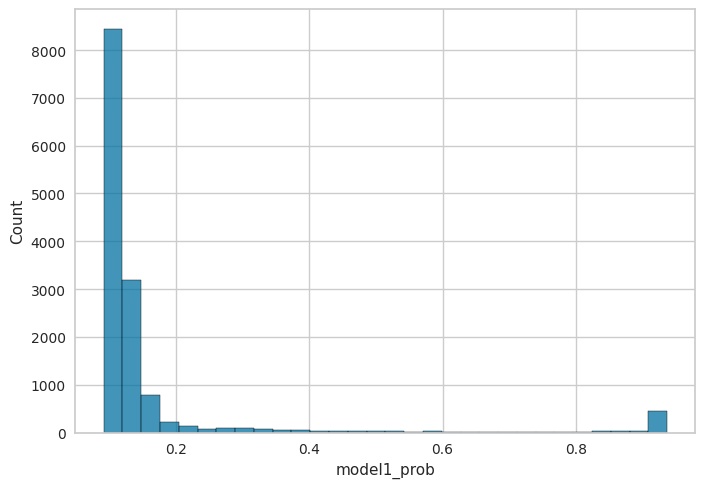

In [32]:
# 예측 불량률인 model1_prob의 분포 확인

sns.histplot(data = AUTO_ML_train4, x = "model1_prob", bins = 30)

Y 변수 값들이 한 쪽으로 치우쳐진 값이기 때문에  
Student의 성능 지표는 MSE보다 MAE가 더 적합할 것이라 생각했습니다.

역시 여러 번에 걸쳐 pycaret을 실행하였고, MAE 값을 작은 순으로 보았을 때,   
성능이 좋았던 모델은 Huber, CatBoost Regressor, GradientBoostingRegressor였습니다.  
하지만 저희는 두 가지의 이유로 CatBoostRegressor를 student model로 선택했습니다.  

첫 번째로 catboost는 표본의 잔차를 모두 다른 모형으로부터 구함으로써 과대적합을 피하는 특성이 있습니다.  
두 번째로 특성변수가 범주형일 때 catboost는 일반적으로 사용하는 one-hot encoding 대신 실수인 순서목표통계량으로 전환해서 사용합니다.  
EDA에서 YEAR 변수를 분석했을 때, YEAR는 단순한 정수형, 범주형이 아닌 순서형 변수였고,  
YEAR가 큰 값일수록 불량률이 낮아지는 경향이 있었기 때문에 순서형 변수에 잘 먹히는 Catboost가 좋을 것이라 판단했습니다.  

In [33]:
# Student model 학습 이후 성능이 높은 순으로 정렬

best5 = compare_models(fold = 5, sort = 'MAE', n_select = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.0573,0.0316,0.1776,-0.0566,0.1226,0.1438,0.1700
catboost,CatBoost Regressor,0.0823,0.0277,0.1664,0.0722,0.1156,0.4124,3.2000
lightgbm,Light Gradient Boosting Machine,0.0826,0.0280,0.1672,0.0631,0.1162,0.4120,0.1620
gbr,Gradient Boosting Regressor,0.0828,0.0278,0.1665,0.0709,0.1150,0.4136,0.7560
knn,K Neighbors Regressor,0.0857,0.0325,0.1803,-0.0896,0.1278,0.4284,0.3580
lr,Linear Regression,0.0861,0.0290,0.1702,0.0297,0.1178,0.4383,0.0600
ridge,Ridge Regression,0.0861,0.0290,0.1702,0.0297,0.1178,0.4384,0.0320
br,Bayesian Ridge,0.0863,0.0290,0.1702,0.0298,0.1177,0.4418,0.0360
lar,Least Angle Regression,0.0865,0.0292,0.1707,0.0242,0.1183,0.4414,0.0340
omp,Orthogonal Matching Pursuit,0.0874,0.0294,0.1714,0.0160,0.1187,0.4508,0.0560


# 4. Teacher model

train, test 데이터에 모두 있는 변수 18개와 AL, BA 변수를 합한 20개의 변수를 이용해 CatBoostClassifier 모델을 적합합니다.  
Optuna를 통해 가장 좋은 초모수를 찾아내고,  
StratifiedKfold를 이용하여 정상, 불량 비율에 따라 데이터를 분류하도록 했습니다.  

In [34]:
train1 = Rdata_train.copy()
test1 = Rdata_test.copy()

In [35]:
train2 = train1.loc[:, ['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR', 'ANONYMOUS_2', 'AG',
                                        'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
                                        'V40', 'ZN', 'Y_LABEL', 'AL', 'BA']]
test2 = test1.drop(['ID'], axis = 1)

print(train2.shape)
print(test2.shape)

(14095, 21)
(6041, 18)


In [36]:
# 범주형 변수인 COMPONENT_ARBITRARY와 YEAR를 LabelEncoder 변환

le1 = LabelEncoder()
le2 = LabelEncoder()

train2['COMPONENT_ARBITRARY_category'] = le1.fit_transform(train2['COMPONENT_ARBITRARY'])
train2['YEAR_category'] = le2.fit_transform(train2['YEAR'])

test2['COMPONENT_ARBITRARY_category'] = le1.transform(test2['COMPONENT_ARBITRARY'])
test2['YEAR_category'] = le2.transform(test2['YEAR'])

# 원래 범주형 변수는 제거해준다.
train3 = train2.drop(['COMPONENT_ARBITRARY', 'YEAR'], axis = 1)
test3 = test2.drop(['COMPONENT_ARBITRARY', 'YEAR'], axis = 1)

categorical_features = ['COMPONENT_ARBITRARY_category', 'YEAR_category']

print(train3.shape)
print(test3.shape)

(14095, 21)
(6041, 18)


In [37]:
# 교차 검증을 위해 X_train을 X_partrain과 X_val로 분할
# stratify 옵션을 사용하여 y의 정상, 불량 비율에 맞게 분할

X_train = train3.drop(['Y_LABEL'], axis = 1)
y_train = train3['Y_LABEL']
X_test = test3

X_partrain, X_val, y_partrain, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 39, stratify = y_train)
print(X_partrain.shape)
print(X_val.shape)
print(y_partrain.shape)
print(y_val.shape)

(9866, 20)
(4229, 20)
(9866,)
(4229,)


Optuna를 이용한 초모수 작업을 실행합니다.

learning_rate는 0.001과 1 사이의 실수값  
n_estimators는 100과 1000 사이의 정수값  
max_depth는 3과 16 사이의 정수값으로 찾았습니다.  

In [38]:
# 초모수는 learning_rate, n_estimators, max_depth 활용

def objective(trial : Trial) -> float :

    params_cat = {
        "random_state" : 39,
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 1),
        "n_estimators" : trial.suggest_int("n_estimators", 100, 1000),
        "max_depth" : trial.suggest_int("max_depth", 3, 16)
  }
    
    model = CatBoostClassifier(**params_cat)
    model.fit(X_partrain, y_partrain, eval_set = [(X_val, y_val)],
              early_stopping_rounds = 100, cat_features = categorical_features, verbose = False)

    cat_pred = model.predict(X_val)
    AUC = roc_auc_score(y_val, cat_pred)
    
    return AUC

In [39]:
# Optuna 초모수 작업 시작

sampler = TPESampler(seed = 39)
study = optuna.create_study(
    study_name = "cat_parameter_opt",
    direction = "maximize",
    sampler = sampler)
study.optimize(objective, n_trials = 100)

[I 2022-12-17 01:00:21,815] A new study created in memory with name: cat_parameter_opt
[I 2022-12-17 01:01:36,341] Trial 0 finished with value: 0.7613481739509061 and parameters: {'learning_rate': 0.04371872304807245, 'n_estimators': 818, 'max_depth': 14}. Best is trial 0 with value: 0.7613481739509061.
[I 2022-12-17 01:01:49,936] Trial 1 finished with value: 0.7570637835267428 and parameters: {'learning_rate': 0.002323537042351288, 'n_estimators': 642, 'max_depth': 10}. Best is trial 0 with value: 0.7613481739509061.
[I 2022-12-17 01:02:06,858] Trial 2 finished with value: 0.7623454181908809 and parameters: {'learning_rate': 0.024644795423723085, 'n_estimators': 524, 'max_depth': 11}. Best is trial 2 with value: 0.7623454181908809.
[I 2022-12-17 01:05:36,392] Trial 3 finished with value: 0.7448569411063718 and parameters: {'learning_rate': 0.5984000779343428, 'n_estimators': 834, 'max_depth': 16}. Best is trial 2 with value: 0.7623454181908809.
[I 2022-12-17 01:06:19,849] Trial 4 fini

In [40]:
# 가장 좋은 초모수와 성능 확인

print("Best Score :", study.best_value)
print("Best trial :", study.best_trial.params)

Best Score : 0.7665005428446204
Best trial : {'learning_rate': 0.03142344166841527, 'n_estimators': 513, 'max_depth': 6}


In [41]:
# 위의 초모수 적용하고, StratifiedKFold을 이용해 모델 적합 

n_fold = 5
cv = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state = 39)

cat_val = np.zeros((X_train.shape[0], 2))
cat_partrain = np.zeros((X_partrain.shape[0], 2))

for i, (i_trn, i_val) in enumerate(cv.split(X_train, y_train), 1):
    print(f'training model for CV #{i}')
    optuna_cat = CatBoostClassifier(
        random_state = 39,
        learning_rate = 0.03142344166841527, 
        n_estimators = 513, 
        max_depth = 6)

    optuna_cat.fit(X_train.loc[i_trn, :], y_train[i_trn], verbose = False, cat_features = categorical_features)

    cat_val[i_val, :] = optuna_cat.predict_proba(X_train.loc[i_val, :])
    cat_partrain += optuna_cat.predict_proba(X_partrain) / n_fold

    # 학습이 완료된 Teacher 모델 5개를 저장 
    with open('Teacher_model' + str(i) + '.pickle', 'wb') as fw:
        pickle.dump(optuna_cat, fw)


training model for CV #1
training model for CV #2
training model for CV #3
training model for CV #4
training model for CV #5


In [42]:
# Teacher model에서 구한 예측불량률을 train 데이터에 넣기

train3['model1_prob'] = cat_val[:, 1]
print(train3.shape)

(14095, 22)


# 5. Student model

train, test 데이터에 모두 있는 변수 18개만을 이용하여 CatBoostRegressor 모델을 적합합니다.  
역시 Optuna를 통해 가장 좋은 초모수를 찾아냈고,  
Kfold를 이용하여 교차 검증을 실시했습니다.

In [43]:
# Student model 적합 위해 18개 변수 이외에 나머지 변수 제거
X_train2 = train3.drop(['AL', 'BA', 'Y_LABEL', 'model1_prob'], axis = 1)
y_train2 = train3['model1_prob']
print(X_train2.shape)
print(y_train2.shape)

(14095, 18)
(14095,)


In [44]:
# 앞에서와 같은 방법으로 데이터 분할

X_partrain, X_val, y_partrain, y_val = train_test_split(X_train2, y_train2, test_size = 0.3, random_state = 39)
print(X_partrain.shape)
print(X_val.shape)
print(y_partrain.shape)
print(y_val.shape)

(9866, 18)
(4229, 18)
(9866,)
(4229,)


앞에서와 같이 Optuna를 이용해 초모수를 찾았습니다.

초모수 작업  
learning_rate는 0.005와 0.5 사이의 실수값  
n_estimators는 400과 1000 사이의 정수값  
max_depth는 3과 10 사이의 정수값으로 찾았습니다.  

CatBoost는 깊이 우선 기반의 모델이기 때문에 max_depth의 최대값을 16에서 10으로 줄이면서  
시간효율을 높였고, Student 모델의 경량화에 집중했습니다.

따라서, 초모수는 'learning_rate': 0.01310047432090872, 'n_estimators': 848, 'max_depth': 9 로 나왔습니다.

In [45]:
# Optuna로 구한 초모수를 적용하고, KFold을 이용해 모델 적합

n_fold = 5
cv = KFold(n_splits = n_fold, shuffle = True, random_state = 39)

cat_val = np.zeros((X_train2.shape[0]))
cat_test = np.zeros((X_test.shape[0]))

print(cat_val.shape)
print(cat_test.shape)

for i, (i_trn, i_val) in enumerate(cv.split(X_train2, y_train2), 1):
    print(f'training model for CV #{i}')
    optuna_cat = CatBoostRegressor(
        random_state = 39,
        learning_rate = 0.01310047432090872, 
        n_estimators = 848, 
        max_depth = 9)

    optuna_cat.fit(X_train2.loc[i_trn, :], y_train2[i_trn], verbose = False, cat_features = categorical_features)

    cat_val[i_val] = optuna_cat.predict(X_train2.loc[i_val, :])
    cat_test += optuna_cat.predict(X_test) / n_fold
    
    # 학습이 완료된 Student 모델 5개를 저장 
    with open('Student_model' + str(i) + '.pickle', 'wb') as fw:
        pickle.dump(optuna_cat, fw)


(14095,)
(6041,)
training model for CV #1
training model for CV #2
training model for CV #3
training model for CV #4
training model for CV #5


# 6. Summit

Student model에서 연속형의 값이 예측값으로 나오므로 기준점인 Threshold를 정해야 합니다.  
train의 예측값을 0.01부터 1.00까지 기준을 정하여 기준점보다 크면 1, 작으면 0으로 예측을 하고  
어떤 기준점일 때 F1_score 값이 큰지를 확인합니다.  
확인할 결과, 0.10과 0.16 사이의 값이 좋을 것으로 판단했고  
Threshold = 0.15일 때가 가장 좋은 성능을 보였습니다.  
따라서 아래와 같이 summission을 만들었습니다.


In [46]:
# Threshold에 따라 변화하는 TP, FP, FN, TN, 그리고 모델 성능 확인

scores = []
TP = []
FP = []
FN = []
TN = []
for threshold in range(50) :
    threshold = threshold / 50
    pred = cat_val
    pred = np.where(pred >= threshold, 1, 0)
    score = f1_score(y_train, pred)
    scores.append(score)
    TP.append(confusion_matrix(y_train, pred)[0][0])
    FN.append(confusion_matrix(y_train, pred)[0][1])
    FP.append(confusion_matrix(y_train, pred)[1][0])
    TN.append(confusion_matrix(y_train, pred)[1][1])
    

temp1 = pd.DataFrame(np.linspace(0, 0.98, 50), columns = ['threshold'])
temp2 = pd.DataFrame(scores, columns = ['score'])
temp3 = pd.DataFrame(TP, columns = ['TP'])
temp4 = pd.DataFrame(FP, columns = ['FP'])
temp5 = pd.DataFrame(FN, columns = ['FN'])
temp6 = pd.DataFrame(TN, columns = ['TN'])
scores = pd.concat([temp1, temp2, temp3, temp4, temp5, temp6], axis = 1)
scores

,threshold,score,TP,FP,FN,TN
0,0.00,0.157409,13,0,12879,1203
1,0.02,0.160011,296,3,12596,1200
2,0.04,0.176768,2378,67,10514,1136
3,0.06,0.203085,5300,209,7592,994
4,0.08,0.228134,7734,384,5158,819
5,0.10,0.246596,9459,551,3433,652
6,0.12,0.260094,10777,707,2115,496
7,0.14,0.257133,11682,847,1210,356
8,0.16,0.230072,12141,949,751,254
9,0.18,0.192861,12399,1022,493,181


In [47]:
# Threshold에 따른 F1 Score Table 만들기

scores = []
for threshold in range(100) :
    threshold = threshold / 100
    pred = cat_val
    pred = np.where(pred >= threshold, 1, 0)
    score = f1_score(y_train, pred)
    scores.append(score)

temp1 = pd.DataFrame(np.linspace(0, 0.99, 100), columns = ['threshold'])
temp2 = pd.DataFrame(scores, columns = ['score'])
scores = pd.concat([temp1, temp2], axis = 1)
scores.loc[: 50, :]

,threshold,score
0,0.00,0.157409
1,0.01,0.157884
2,0.02,0.160011
3,0.03,0.165590
4,0.04,0.176768
5,0.05,0.188969
6,0.06,0.203085
7,0.07,0.216171
8,0.08,0.228134
9,0.09,0.241206


In [48]:
# 가장 좋은 F1 Score일 때의 Threshold 확인

scores.loc[scores['score'] == scores['score'].max(), :]

,threshold,score
13,0.13,0.261438


In [49]:
# answer 만들기

answer = np.zeros(cat_test.shape[0])

for i in range(cat_test.shape[0]) :
  if cat_test[i] >= 0.15 :
    answer[i] = 1
    
answer = answer.astype('int64')
print(Counter(answer))

Counter({0: 5520, 1: 521})


In [50]:
submission_preds = answer
submission = pd.read_csv('/home/studio-lab-user/MYDATA/Construction Machine Oil/open/sample_submission.csv')
submission['Y_LABEL'] = submission_preds
submission.to_csv('/home/studio-lab-user/MYDATA/Construction Machine Oil/결과/submission_CatBoost.csv', index = False)